In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as T

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 设置随机种子
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Using device: cpu


In [2]:
# In[2]
class BrainHemorrhageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir:  C:/Users/zhang/Desktop/Final Project/renders
        transform: 
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # 六个类别文件夹
        self.classes = [
            'subdural',
            'subarachnoid',
            'intraventricular',
            'intraparenchymal',
            'epidural',
            'normal'
        ]
        
        # 存储 (四通道图像路径列表, label)
        self.samples = []
        
        # 遍历每个类别
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_name)
            
            # 四种窗口
            window_types = [
                'brain_bone_window',
                'brain_window',
                'max_contrast_window',
                'subdural_window'
            ]
            
            # 以第一个窗口子文件夹为参考，收集所有文件名
            reference_window = window_types[0]
            reference_path = os.path.join(class_path, reference_window)
            
            # 获取该窗口下的所有图像文件 
            all_files = glob.glob(os.path.join(reference_path, '*.*'))
            
            for ref_file in all_files:
                filename = os.path.basename(ref_file)
                
                # 拼出四个窗口完整路径
                channel_paths = []
                for w in window_types:
                    w_full_path = os.path.join(class_path, w, filename)
                    if not os.path.exists(w_full_path):
                        break  # 若有缺失，跳过
                    channel_paths.append(w_full_path)
                
                # 如果四个窗口都存在，加入样本列表
                if len(channel_paths) == 4:
                    self.samples.append((channel_paths, class_idx))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        channel_paths, label = self.samples[idx]
        
        # 读取四个通道
        channels = []
        for path in channel_paths:
            img = Image.open(path).convert('L')  # 转灰度
            channels.append(img)
        
        # 对每个通道进行 transform
        if self.transform is not None:
            channels_t = [self.transform(ch) for ch in channels]
        else:
            channels_t = [T.ToTensor()(ch) for ch in channels]
        
        # 每个通道形状 [1, H, W], 合并后 [4, H, W]
        img_4ch = torch.cat(channels_t, dim=0)
        
        label = torch.tensor(label, dtype=torch.long)
        return img_4ch, label

In [3]:
# In[3]
# 数据预处理
transform = T.Compose([
    T.Resize((224, 224)),  # 统一到 224x224
    T.ToTensor()
])

root_dir = r"C:\Users\zhang\Desktop\Final Project\renders"
full_dataset = BrainHemorrhageDataset(root_dir, transform=transform)
full_size = len(full_dataset)

print("全部样本数量 =", full_size)

# 只取 10%
sample_size = int(0.1 * full_size)
indices = list(range(full_size))
random.shuffle(indices)
subset_indices = indices[:sample_size]

# 创建一个新的小数据集
subset_dataset = Subset(full_dataset, subset_indices)
print("抽取 10% 后的样本数量 =", len(subset_dataset))

# 再在这个 10% 中做 8:2 的训练/测试拆分
train_ratio = 0.8
train_size = int(len(subset_dataset) * train_ratio)
test_size = len(subset_dataset) - train_size

train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# 创建 DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

全部样本数量 = 81939
抽取 10% 后的样本数量 = 8193
Train dataset size: 6554
Test dataset size: 1639


In [6]:
class ComplexCNN(nn.Module):
    """
    相比 SimpleCNN, 增加卷积块层数 & 使用BatchNorm, 并在全连接层做更深的结构.
    适合在数据量更大时使用. 输入形状 [B, 4, 224, 224], 输出6类.
    """
    def __init__(self, num_classes=6):
        super(ComplexCNN, self).__init__()
        
        # 第1块: Conv -> BN -> ReLU -> MaxPool -> Dropout
        self.block1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 224 -> 112
            nn.Dropout(p=0.25)
        )
        
        # 第2块: Conv -> BN -> ReLU -> MaxPool -> Dropout
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 112 -> 56
            nn.Dropout(p=0.25)
        )
        
        # 第3块: Conv -> BN -> ReLU -> MaxPool -> Dropout
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 56 -> 28
            nn.Dropout(p=0.25)
        )
        
        # 第4块: Conv -> BN -> ReLU -> MaxPool -> Dropout
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 28 -> 14
            nn.Dropout(p=0.25)
        )
        
        # 经过4次池化, 尺寸从224 -> 14 (224 -> 112 -> 56 -> 28 -> 14)
        # 通道数=256 => Flatten后 [256 * 14 * 14]
        # 256 * 14 * 14 = 50176
        
        # 构建分类器部分: 两层全连接 + Dropout
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(128, num_classes)  # 最终输出6类
        )

    def forward(self, x):
        # 依次通过4个卷积块
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # 全连接层
        x = self.classifier(x)
        return x
model = ComplexCNN(num_classes=6).to(device)
print(model)

ComplexCNN(
  (block1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [7]:
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10  
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
#训练
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 使用 tqdm 对 train_loader 做迭代包装，在每次 epoch 时显示实时进度
    # desc 参数可显示当前 epoch 信息
    # leave=True改为 True 让进度条一直显示
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 可在进度条上动态显示当前batch的loss
        pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})
    
    # 计算并记录当前epoch的平均损失和准确率
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # ====== 测试 ======
    model.eval()
    running_loss_test = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss_test += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    epoch_loss_test = running_loss_test / total_test
    epoch_acc_test = correct_test / total_test
    test_losses.append(epoch_loss_test)
    test_accuracies.append(epoch_acc_test)
    
    # 这里在每个 epoch 结束后打印一次结果
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Test Loss: {epoch_loss_test:.4f}, Test Acc: {epoch_acc_test:.4f}")


Epoch 1/10:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch [1/10] Train Loss: 1.6565, Train Acc: 0.3337 | Test Loss: 1.5572, Test Acc: 0.3868


Epoch 2/10:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch [2/10] Train Loss: 1.5517, Train Acc: 0.3787 | Test Loss: 1.5452, Test Acc: 0.3874


Epoch 3/10:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch [3/10] Train Loss: 1.5460, Train Acc: 0.3906 | Test Loss: 1.5457, Test Acc: 0.4009


Epoch 4/10:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch [4/10] Train Loss: 1.5267, Train Acc: 0.3914 | Test Loss: 1.5325, Test Acc: 0.3996


Epoch 5/10:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch [5/10] Train Loss: 1.5101, Train Acc: 0.3985 | Test Loss: 1.5138, Test Acc: 0.4002


Epoch 6/10:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch [6/10] Train Loss: 1.5013, Train Acc: 0.3995 | Test Loss: 1.5045, Test Acc: 0.4051


Epoch 7/10:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch [7/10] Train Loss: 1.4976, Train Acc: 0.4042 | Test Loss: 1.4784, Test Acc: 0.4027


Epoch 8/10:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch [8/10] Train Loss: 1.4883, Train Acc: 0.4025 | Test Loss: 1.4751, Test Acc: 0.4088


Epoch 9/10:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch [9/10] Train Loss: 1.4861, Train Acc: 0.4002 | Test Loss: 1.4642, Test Acc: 0.4063


Epoch 10/10:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch [10/10] Train Loss: 1.4765, Train Acc: 0.4045 | Test Loss: 1.4583, Test Acc: 0.4106


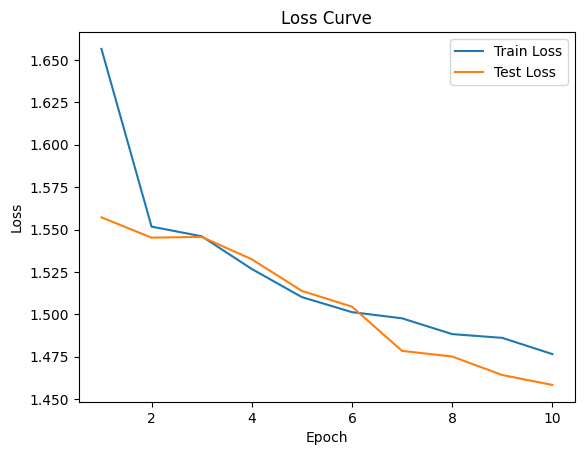

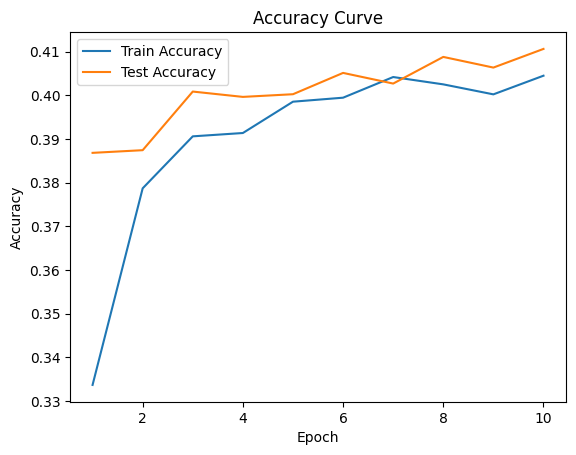

In [8]:
#绘制损失与准确率曲线
epochs_range = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()